<h1><center>

![](https://i.imgur.com/jrRGMfx.png)

AI PRACTITIONER COURSE 

PRACTICE LAB - SESSION 20 - Deep Convolutional Neural Network

**&copy; 2020 VTCA-COTAI. Internal Use Only.**

</center></h1>


**DATASET LINK** https://drive.google.com/drive/folders/1HbSDeE6FZhLtZOOCezdrlrP-D4vwP31j?usp=sharing

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.random import set_seed
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import draw
from tensorflow.keras.backend import clear_session

# Excercise: Bounding Box Regressor

## Goal

Học được cách sử dụng các Pretrained Model có sẵn do Tensorflow cung cấp

## Prepare Dataset



Bài tập này chúng ta sẽ tiến hành huấn luyện module xác định bounding box khoanh vùng mặt của một con mèo (Cat Face). Tập dữ liệu Cat Dataset bao gồm khoảng 10.000 được download tại trang web sau: https://web.archive.org/web/20150520175645/http://137.189.35.203/WebUI/CatDatabase/catData.html

Dưới đây là một số ảnh nằm trong dataset này.

![Một số ảnh mèo trong dataset](https://web.archive.org/web/20150520175645im_/http://137.189.35.203/WebUI/CatDatabase/Samples.jpg)

**Annotation:**
Dataset gồm có 7 thư mục ảnh 'CAT_00' đến 'CAT_06'. Trong các thư mục ảnh này sẽ có một cặp file có cùng tên khác phần mở rộng tương ứng là ảnh gốc và file chứa các điểm gán nhãn. Ví dụ như cặp file (00000003_015.jpg , 00000003_015.jpg.cat). File .cat sẽ có 9 cặp điểm tương ứng với các bộ phận trên mặt của một con mèo như: đỉnh tai, mắt, mũi, miệng, ...
Lưu ý rằng trong bài toán phát hiện mặt mèo này, chúng ta không cần thông tin của các đỉnh này mà chỉ cần quan tâm đến đường bao (bounding box) xung quanh mặt của một con mèo được tạo dựa trên các đỉnh này.

![cat annotation](https://web.archive.org/web/20150520175645im_/http://137.189.35.203/WebUI/CatDatabase/annotation.png)


**Constansts**

In [ ]:
MODEL_IMAGE_HEIGHT = 128
MODEL_IMAGE_WIDTH = 128
MODEL_INPUT_SHAPE = (MODEL_IMAGE_HEIGHT,MODEL_IMAGE_WIDTH,3)

# Change it
CURRENT_DIR = '/content/drive/MyDrive/Colab Notebooks/s20/Cat_BoundingBox'

PATH_TO_X = os.path.join(CURRENT_DIR, 'data_X.pkl')
PATH_TO_Y = os.path.join(CURRENT_DIR, 'data_y.pkl')

SAVE_BEST_WEIGHTS_FILEPATH = os.path.join('/content', 'best_weights', 'best_model')
SAVE_WEIGHTS_CHECKPOINT_FILEPATH = os.path.join('/content', 'ckp', 'weights.{epoch:02d}-{val_loss:.2f}')

**Load dữ liệu từ file pickle**

In [ ]:
# TODO
# 1. Google search "How to load data with pickle"
# 2. Complete load_data() function below
# 3. Call load_data() function for X and y

import pickle
def load_data(path):
  files = open(path,'rb')
  return pickle.load(files)

# call load_data here
X = load_data(PATH_TO_X)
Y = load_data(PATH_TO_Y)

**Kiểm tra dữ liệu**

In [ ]:
# TODOs
print(X.shape)
print(Y.shape)

(8784, 128, 128, 3)
(8784, 4)


**Các hàm hỗ trợ**

Một số hàm cơ bản phục vụ cho quá trình huấn luyện như:
- ``plot_learning_curve``: vẽ learning curve trên tập Train và Validation sau khi huấn luyện.
- ``unnormalize_prediction``: biến đổi vector output đầu ra thành dạng toạ độ ảnh hệ toạ độ nguyên theo pixel. Bước này là để khôi phục hệ toạ độ bounding box từ dạng đã chuẩn hoá (normalized) có miền giá trị 0-1 sang hệ toạ độ theo pixel của ảnh trong tập dữ liệu.
- ``draw_predicted_rectangle``: vẽ bounding box dự đoán từ hệ thống lên ảnh. Bước này bao gồm việc chuẩn hoá ngược sang hệ pixel và vẽ lên trên ảnh màu.
- ``clip``: để đảm bảo rằng toạ độ đều không âm và không vượt quá khuôn khổ ảnh.



In [ ]:
def plot_learning_curve(history):
  # TODO
  plt.figure(figsize=(15, 10))
  plt.plot(history.history['loss'], label='Training Loss')
  plt.plot(history.history['val_loss'], label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Loss vs Epoch')
  plt.show()

def unnormalize_prediction(y, x, half_height, half_width, \
                           img_height=MODEL_IMAGE_HEIGHT, img_width=MODEL_IMAGE_WIDTH):
    """Transforms a predictions from normalized (0 to 1) y, x, half-width,
    half-height to pixel values (top left y, top left x, bottom right y,
    bottom right x).
    Args:
        y: Normalized y coordinate of rectangle center.
        x: Normalized x coordinate of rectangle center.
        half_height: Normalized height of rectangle.
        half_width: Normalized width of rectangle.
        img_height: Height of the image to use while unnormalizing.
        img_width: Width of the image to use while unnormalizing.
    Returns:
        (top left y in px, top left x in px, bottom right y in px,
        bottom right x in px)
    """
    # calculate x, y of corners in pixels
    tl_y = int((y - half_height) * img_height)
    tl_x = int((x - half_width) * img_width)
    br_y = int((y + half_height) * img_height)
    br_x = int((x + half_width) * img_width)

    # make sure that x and y coordinates are within image boundaries
    tl_y = clip(0, tl_y, img_height-2)
    tl_x = clip(0, tl_x, img_width-2)
    br_y = clip(0, br_y, img_height-1)
    br_x = clip(0, br_x, img_width-1)

    # make sure that top left corner is really top left of bottom right values
    if tl_y > br_y:
        tl_y, br_y = br_y, tl_y
    if tl_x > br_x:
        tl_x, br_x = br_x, tl_x

    # make sure that the area covered is at least 1px,
    # move preferably the top left corner
    # but dont move it outside of the image
    if tl_y == br_y:
        if tl_y == 0:
            br_y += 1
        else:
            tl_y -= 1

    if tl_x == br_x:
        if tl_x == 0:
            br_x += 1
        else:
            tl_x -= 1

    return tl_y, tl_x, br_y, br_x

def draw_predicted_rectangle(image_arr, bb, bb_pred=None):
    """Draws a rectangle onto the image at the provided coordinates.
    Args:
        image_arr: Numpy array of the image.
        y: y-coordinate of the rectangle (normalized to 0-1).
        x: x-coordinate of the rectangle (normalized to 0-1).
        half_height: Half of the height of the rectangle (normalized to 0-1).
        half_width: Half of the width of the rectangle (normalized to 0-1).
    Returns:
        Modified image (numpy array)
    """
    height = image_arr.shape[0]
    width = image_arr.shape[1]
    y, x, half_height, half_width = bb
    tl_y, tl_x, br_y, br_x = unnormalize_prediction(y, x, half_height, half_width, \
                                                    img_height=height, img_width=width)
    image_arr = np.copy(image_arr) * 255
    image_arr = draw_rectangle(image_arr, tl_y, tl_x, br_y, br_x)
    if bb_pred is not None:
      y, x, half_height, half_width = bb_pred
      tl_y, tl_x, br_y, br_x = unnormalize_prediction(y, x, half_height, half_width, \
                                                    img_height=height, img_width=width)
      image_arr = draw_rectangle(image_arr, tl_y, tl_x, br_y, br_x)

    return image_arr

def draw_rectangle(img, tl_y, tl_x, br_y, br_x):
    """Draws a rectangle onto an image.
    Args:
        img: The image as a numpy array of shape (row, col, channel).
        tl_y: Top left y coordinate as pixel.
        tl_x: Top left x coordinate as pixel.
        br_y: Top left y coordinate as pixel.
        br_x: Top left x coordinate as pixel.
    Returns:
        image with rectangle
    """
    assert img.shape[2] == 3, img.shape[2]
    img = np.copy(img)
    lines = [
        (tl_y, tl_x, tl_y, br_x), # top left to top right
        (tl_y, br_x, br_y, br_x), # top right to bottom right
        (br_y, br_x, br_y, tl_x), # bottom right to bottom left
        (br_y, tl_x, tl_y, tl_x)  # bottom left to top left
    ]
    for y0, x0, y1, x1 in lines:
        rr, cc, val = draw.line_aa(y0, x0, y1, x1)
        img[rr, cc, 0] = val * 255

    return img.astype(np.uint8)

def clip(lower, val, upper):
    """Clips a value. For lower bound L, upper bound U and value V it
    makes sure that L <= V <= U holds.
    Args:
        lower: Lower boundary (including)
        val: The value to clip
        upper: Upper boundary (including)
    Returns:
        value within bounds
    """
    if val < lower:
        return lower
    elif val > upper:
        return upper
    else:
        return val




**Train Test Split**

In [ ]:
# TODO
# 1. Split dataset into 3 set: Train, Validation, Test (70%-15%-15%)
# TODO
# from sklearn.model_selection import train_test_split

# split train and val
# X_train, X_val, Y_train, Y_val = train_test_split(X, Y, shuffle=True, test_size=0.3, random_state=1612)
# X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, shuffle=True, test_size=0.5, random_state=1612)

# print((X_train.shape, Y_train.shape))
# print((X_val.shape, Y_val.shape))
# print((X_test.shape, Y_test.shape))
from sklearn.model_selection import train_test_split as tts 

X_train,X_test,Y_train,Y_test = tts(X,Y,shuffle = True,test_size = 0.3, random_state = 1612)
X_test,X_val,Y_test,Y_val = tts(X_test,Y_test,shuffle = True,test_size = 0.5, random_state = 1612)


In [ ]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)
print(X_val.shape,y_val.shape)

(6148, 128, 128, 3) (6148, 4)
(1318, 128, 128, 3) (1318, 4)
(1318, 128, 128, 3) (1318, 4)


## Visualize Data

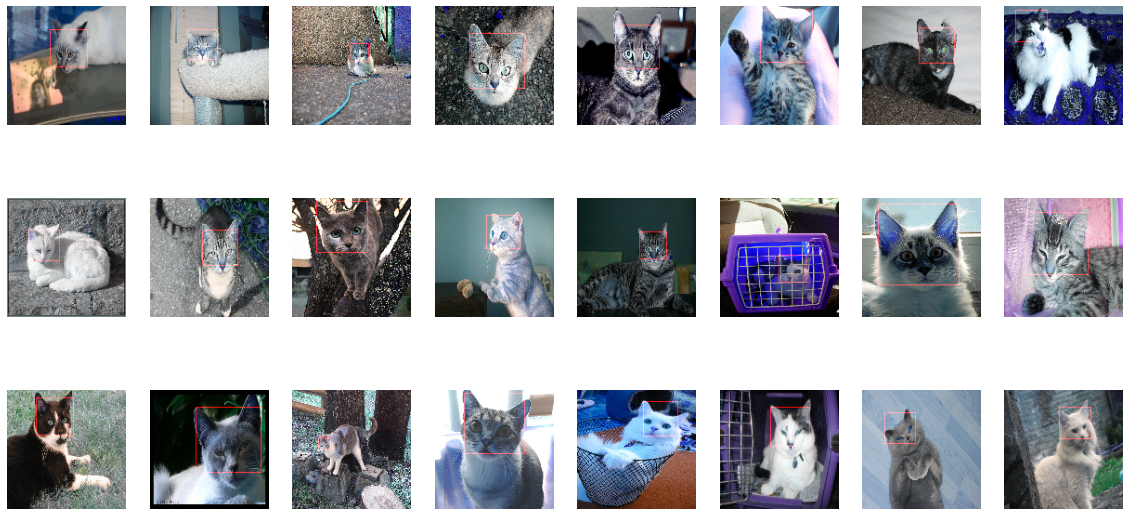

In [ ]:
np.random.seed(42)

cols = 8
rows = 3
fig = plt.figure(figsize=(20,10))
for i in range(cols):
    for j in range(rows):
      # TODO
      random_index = np.random.randint(0, X_test.shape[0])
      ax = fig.add_subplot(rows, cols, i * rows + j + 1)
      ax.grid('off')
      ax.axis('off')
      temp = X_test[random_index,:]
      img = draw_predicted_rectangle(temp, Y_test[random_index])
      ax.imshow(img)
plt.show()

## Create and Train Model

In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input

def create_model(loss, optimizer):
    input = Input(shape = MODEL_INPUT_SHAPE)
    x = preprocess_input(input)
    feature_extracting = ResNet50V2(
        include_top = False,
        weights = 'imagenet',
        pooling = 'avg',
        input_shape = MODEL_INPUT_SHAPE
    )
    feature_extracting.trainable = False
    x = feature_extracting(x)
    x = Dense(512, kernel_initializer = 'he_uniform')(x)
    x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    output = Dense(4,activation = 'linear')(x)
    model = Model(inputs = input, outputs = output)
    model.compile(loss= loss, optimizer = optimizer)
    return model

  # TODO
  
model = create_model('mse','adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
tf.math.truediv_2 (TFOpLambd (None, 128, 128, 3)       0         
_________________________________________________________________
tf.math.subtract_2 (TFOpLamb (None, 128, 128, 3)       0         
_________________________________________________________________
resnet50v2 (Functional)      (None, 2048)              23564800  
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
activation (Activation)      (None, 512)               0     

**Create and train model**

In [ ]:
clear_session()
set_seed(42)
np.random.seed(42)

checkpoint_cb = ModelCheckpoint(SAVE_WEIGHTS_CHECKPOINT_FILEPATH, verbose=0, 
                                save_weights_only=True, save_freq='epoch')

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=1)

# TODO
# 1. Call create_model
# 2. Fit model using 2 callbacks above, return history
# 3. Evaluate on Test Set
# 4. Draw Learning Curve
model = create_model('mse','adam')
model.fit(X_train,Y_train,
          batch_size = 64,
          epochs = 10,
          validation_data = (X_val,Y_val),
          callbacks = [checkpoint_cb,reduce_lr])

Epoch 1/10
97/97 [==============================] - 16s 65ms/step - loss: 0.5603 - val_loss: 0.0104
Epoch 2/10
97/97 [==============================] - 5s 50ms/step - loss: 0.0186 - val_loss: 0.0097
Epoch 3/10
97/97 [==============================] - 5s 51ms/step - loss: 0.0147 - val_loss: 0.0093
Epoch 4/10
97/97 [==============================] - 5s 50ms/step - loss: 0.0132 - val_loss: 0.0085
Epoch 5/10
97/97 [==============================] - 5s 50ms/step - loss: 0.0126 - val_loss: 0.0086
Epoch 6/10
97/97 [==============================] - 5s 51ms/step - loss: 0.0116 - val_loss: 0.0085
Epoch 7/10
97/97 [==============================] - 5s 51ms/step - loss: 0.0111 - val_loss: 0.0085
Epoch 8/10
97/97 [==============================] - 5s 51ms/step - loss: 0.0109 - val_loss: 0.0082
Epoch 9/10
97/97 [==============================] - 5s 51ms/step - loss: 0.0105 - val_loss: 0.0085
Epoch 10/10
97/97 [==============================] - 5s 50ms/step - loss: 0.0105 - val_loss: 0.0082


In [ ]:
model.evaluate(X_test,Y_test)

42/42 [==============================] - 1s 30ms/step - loss: 0.0086


0.008557739667594433

## Inference

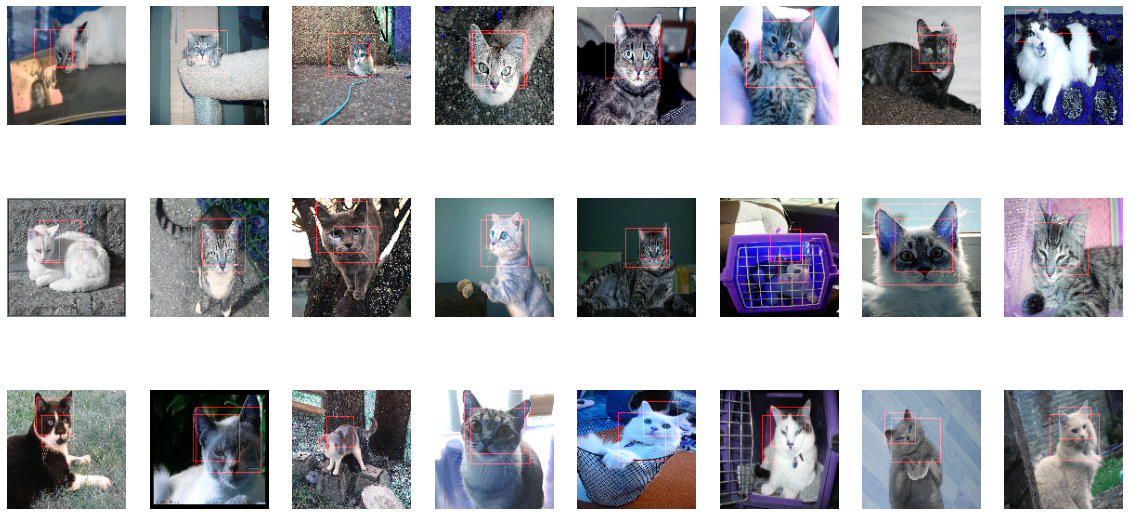

In [ ]:

cols = 8
rows = 3
fig = plt.figure(figsize=(20,10))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, X_test.shape[0])
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        temp = X_test[random_index,:]
        y_pred = model.predict(temp.reshape(1, MODEL_IMAGE_WIDTH, MODEL_IMAGE_WIDTH, 3))
        img = draw_predicted_rectangle(temp, Y_test[random_index], y_pred[0])
        ax.imshow(img)
plt.show()